# Day 6: Autocorrelation Analysis (ACF & PACF)

### Import and setup libraries

In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "ggplot2" 

### Data imports and preprocessing

In [10]:
gold = pd.read_csv("../data/gold_prices.csv", parse_dates=["Date"], index_col="Date")

# Preprocess data to match with spot prices approximately
gold['Price'] = gold['Price'].astype(float)
gold['Price'] = gold['Price'] * 10.8
gold['Price'] = gold['Price'].round(0)

In [7]:
px.line(gold, x=gold.index, y="Price", title="Gold Prices (GLD) Over Time", labels={"Price": "Price (USD)"})

## Understanding ACF and PACF

**Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** are essential tools for identifying ARIMA model parameters.

### ACF (Autocorrelation Function)
- Measures correlation between the time series and its lagged values
- Includes both direct and indirect relationships
- **Helps identify the Moving Average (MA) order → q parameter**
- In MA(q) models, ACF cuts off after lag q

### PACF (Partial Autocorrelation Function)  
- Measures correlation between the time series and its lagged values, **controlling for intermediate lags**
- Shows only direct relationships
- **Helps identify the Autoregressive (AR) order → p parameter**
- In AR(p) models, PACF cuts off after lag p

### Significance Testing
Both plots show confidence intervals (blue shaded area). Lags that exceed these bounds are statistically significant and suggest dependencies that should be modeled.

## 1. Apply Differencing

First, we need to apply first-order differencing to the gold prices (as learned in Day 5) to achieve stationarity.

## 2. ACF and PACF Plots

Let's visualize the ACF and PACF for the differenced gold prices to identify potential ARIMA parameters.

In [11]:
# Apply first-order differencing
gold['Price_Diff'] = gold['Price'].diff()

# Remove NaN values for analysis
gold_diff_clean = gold['Price_Diff'].dropna()

print(f"Original data points: {len(gold)}") 
print(f"Differenced data points (after removing NaN): {len(gold_diff_clean)}")
print(f"\\nFirst few differenced values:")
print(gold_diff_clean.head())

Original data points: 2515
Differenced data points (after removing NaN): 2514
\nFirst few differenced values:
Date
2016-01-12    -6.0
2016-01-13     6.0
2016-01-14   -18.0
2016-01-15    11.0
2016-01-19    -1.0
Name: Price_Diff, dtype: float64


## 3. Interpreting the Correlograms

### Reading the Plots

**Significance Threshold:**
- The blue shaded area represents the 95% confidence interval
- Lags that extend beyond this area are statistically significant
- These significant lags indicate dependencies we should model

### ACF Analysis (Left Plot)
The ACF plot shows how the current value correlates with past values at different lags.

**What to look for:**
- **Sharp cutoff**: Suggests MA(q) process - count lags before cutoff
- **Gradual decay**: Suggests AR process - look to PACF for order
- **Significant spikes**: Individual lags with strong correlation

### PACF Analysis (Right Plot)  
The PACF plot shows direct correlation after removing indirect effects.

**What to look for:**
- **Sharp cutoff**: Suggests AR(p) process - count lags before cutoff
- **Gradual decay**: Suggests MA process - look to ACF for order
- **Significant spikes**: Direct autoregressive relationships

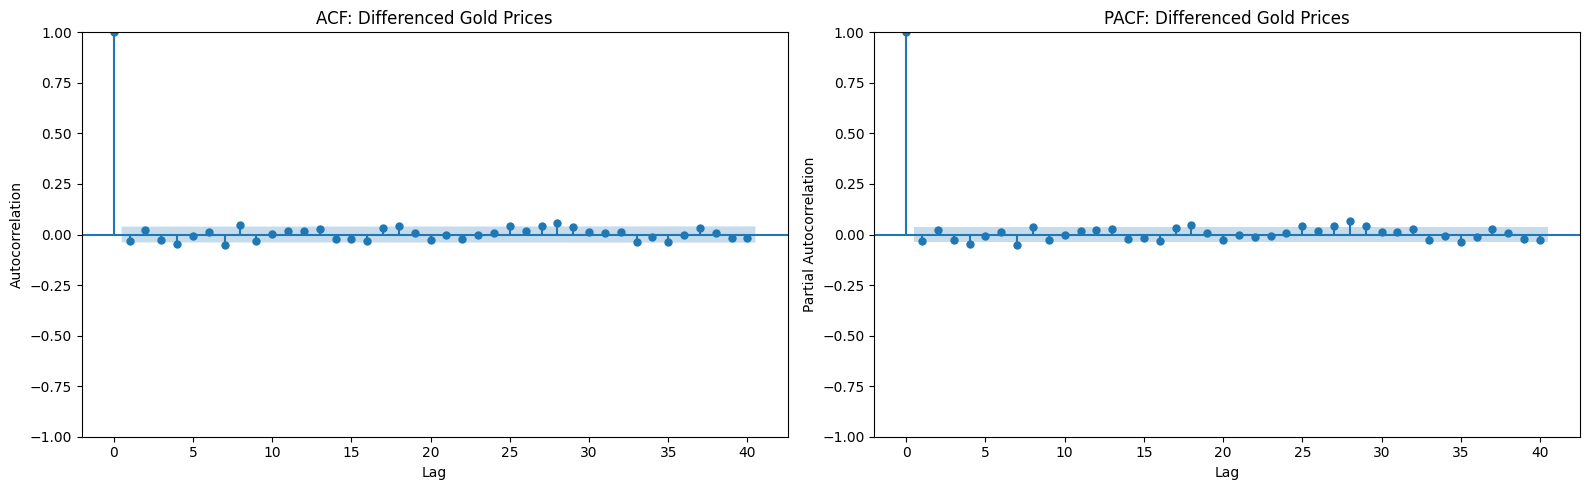

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF Plot
plot_acf(gold_diff_clean, lags=40, ax=axes[0], title='ACF: Differenced Gold Prices')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# PACF Plot
plot_pacf(gold_diff_clean, lags=40, ax=axes[1], title='PACF: Differenced Gold Prices')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

## 4. Key Finding: White Noise Behavior

**Observation:** Both the ACF and PACF plots show essentially **no significant correlation** at any lag beyond lag 0.

This is a critical finding! It indicates that:

### What This Means

1. **The differenced gold prices follow a white noise process** - there are no temporal dependencies or patterns to model
2. **The original prices are a random walk** - each day's price change is independent and unpredictable
3. **This is the expected behavior for efficient financial markets** - prices should be unpredictable; if they followed patterns, traders would exploit them away

### Implications for ARIMA Modeling

When you have white noise (no correlation structure):
- **p = 0** (no AR terms needed - no autoregressive patterns)
- **d = 1** (one differencing applied to achieve stationarity)
- **q = 0** (no MA terms needed - no moving average patterns)
- **Best model: ARIMA(0,1,0)**

This is simply a **random walk with drift**, which is the most appropriate model for gold prices.

### Statistical Confirmation

You could optionally compute the Ljung-Box test to formally confirm white noise:
```python
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(gold_diff_clean, lags=[10, 20], return_df=True)
print(lb_test)
# p-values > 0.05 confirm no significant autocorrelation
```

If all p-values > 0.05, it confirms the series is white noise.

### Why No Correlation is Actually Good

- **Validates market efficiency:** Suggests prices reflect all available information
- **Simplifies modeling:** No complex ARIMA structure needed
- **Implies:** Best predictions for next-day price = today's price (plus a drift/trend if present)
- **For trading:** Past patterns won't reliably predict future prices